# Sentiment Analysis of YouTube Titles
This notebook aims to run sentiment analysis model to detect the sentiment of video titles.

In [ ]:
# Import packages
import pandas as pd
import re
import emoji #pip install emoji
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize, word_tokenize
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from textblob import TextBlob

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Change to your own directory
try: 
    os.chdir("/Users/Jiayi/Documents/GitHub/youtube_analysis")
    print("Directory changed")
except OSError:
    print("Can't change the Current Working Directory")      

## Importing of Files

In [1]:
videodf = pd.read_csv("data/pooled_videos_df.csv")
stop_words = [word.strip() for word in open('data/stop_words.txt').readlines()]
videodf.head()

,channelId,description,publishedAt,videoId,thumbnails,videoTitle,commentCount,dislikeCount,likeCount,viewCount
0,UCjOl2AUblVmg2rA_cRgZkFg,"In this week's Top Gear, Flintoff gets his han...",2020-10-09 09:35:54,NXX338WY_Lw,https://i.ytimg.com/vi/NXX338WY_Lw/default.jpg,PREVIEW: Attempting 200mph in the Jaguar XJ220...,528.0,257.0,5819.0,184447.0
1,UCjOl2AUblVmg2rA_cRgZkFg,"From the humble new Volkswagen GTI, right down...",2020-10-09 11:21:23,dtHcdU2c71Y,https://i.ytimg.com/vi/dtHcdU2c71Y/default.jpg,Which car will win Top Gear Speed Week 2020? (...,568.0,273.0,7136.0,217619.0
2,UCjOl2AUblVmg2rA_cRgZkFg,Here's Chris Harris' take on the rocket-disgui...,2020-10-07 07:40:22,vnrtWe-RAzg,https://i.ytimg.com/vi/vnrtWe-RAzg/default.jpg,Chris Harris on... the Ferrari SF90 Stradale |...,1091.0,408.0,10189.0,437777.0
3,UCjOl2AUblVmg2rA_cRgZkFg,"16 contenders, 8,553bhp and a festival to reme...",2020-10-06 13:59:38,Ra1F0TsOCPs,https://i.ytimg.com/vi/Ra1F0TsOCPs/default.jpg,Chris Harris vs 2020’s Best Performance Cars |...,579.0,202.0,7126.0,191070.0
4,UCjOl2AUblVmg2rA_cRgZkFg,"The 986bhp Ferrari SF90 is, unsurprisingly, no...",2020-10-06 07:36:13,fXysipmTxcQ,https://i.ytimg.com/vi/fXysipmTxcQ/default.jpg,FASTEST TOP GEAR LAP? Ferrari SF90 Stiglap | T...,888.0,168.0,9697.0,572569.0


In [2]:
titlelist = list(videodf['videoTitle'])
print(len(titlelist))

407093


## Data Cleaning of Video Titles
Accounting for emojis in title by decoding them

In [28]:
def char_is_emoji(character):
    return character in emoji.UNICODE_EMOJI


def text_has_emoji(text):
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            return True
    return False

# add space near your emoji
def add_space(text):
    return ''.join(' ' + char if char_is_emoji(char) else char for char in text).strip()

In [31]:
have_emoji = []
spaceTitle = []

for title in titlelist:
    title = add_space(title)
    spaceTitle.append(title)
    if text_has_emoji(title):
        have_emoji.append(1)
    else:
        have_emoji.append(0)

print(sum(have_emoji)) ##3264 titles have emojis in them

3264


In [65]:
decodedTitleList = []

for i in range(len(titlelist)):
    title = titlelist[i]
    if have_emoji[i] == 1:
        title = spaceTitle[i]
        words = title.split(" ")
        for i in range(len(words)):
            word = words[i]
            if char_is_emoji(word):
                #decoded emoji comes in the form ':decoded_emoji:'
                code = str(emoji.demojize(word))[1:-1] #to remove ':'
                newCode = code.replace('_',' ') #to replace '_' with ' '
                words[i] = newCode
        sentence = ' '.join(words)
        decodedTitleList.append(sentence)
    else:
        decodedTitleList.append(title)

In [67]:
videodf['decodedTitles'] = decodedTitleList
videodf.head()

,channelId,description,publishedAt,videoId,thumbnails,videoTitle,commentCount,dislikeCount,likeCount,viewCount,decodedTitles
0,UCjOl2AUblVmg2rA_cRgZkFg,"In this week's Top Gear, Flintoff gets his han...",2020-10-09 09:35:54,NXX338WY_Lw,https://i.ytimg.com/vi/NXX338WY_Lw/default.jpg,PREVIEW: Attempting 200mph in the Jaguar XJ220...,528.0,257.0,5819.0,184447.0,PREVIEW: Attempting 200mph in the Jaguar XJ220...
1,UCjOl2AUblVmg2rA_cRgZkFg,"From the humble new Volkswagen GTI, right down...",2020-10-09 11:21:23,dtHcdU2c71Y,https://i.ytimg.com/vi/dtHcdU2c71Y/default.jpg,Which car will win Top Gear Speed Week 2020? (...,568.0,273.0,7136.0,217619.0,Which car will win Top Gear Speed Week 2020? (...
2,UCjOl2AUblVmg2rA_cRgZkFg,Here's Chris Harris' take on the rocket-disgui...,2020-10-07 07:40:22,vnrtWe-RAzg,https://i.ytimg.com/vi/vnrtWe-RAzg/default.jpg,Chris Harris on... the Ferrari SF90 Stradale |...,1091.0,408.0,10189.0,437777.0,Chris Harris on... the Ferrari SF90 Stradale |...
3,UCjOl2AUblVmg2rA_cRgZkFg,"16 contenders, 8,553bhp and a festival to reme...",2020-10-06 13:59:38,Ra1F0TsOCPs,https://i.ytimg.com/vi/Ra1F0TsOCPs/default.jpg,Chris Harris vs 2020’s Best Performance Cars |...,579.0,202.0,7126.0,191070.0,Chris Harris vs 2020’s Best Performance Cars |...
4,UCjOl2AUblVmg2rA_cRgZkFg,"The 986bhp Ferrari SF90 is, unsurprisingly, no...",2020-10-06 07:36:13,fXysipmTxcQ,https://i.ytimg.com/vi/fXysipmTxcQ/default.jpg,FASTEST TOP GEAR LAP? Ferrari SF90 Stiglap | T...,888.0,168.0,9697.0,572569.0,FASTEST TOP GEAR LAP? Ferrari SF90 Stiglap | T...


## Data Exploration of Video Titles

In [6]:
top_N = 100
#convert list of list into text
#a=''.join(str(r) for v in df_usa['title'] for r in v)

a = videodf['videoTitle'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

#remove all the stopwords from the text
stop_words = [word.strip() for word in open('data/stop_words.txt').readlines()]       
nltk_words = list(stopwords.words('english'))   
stop_words.extend(nltk_words)

word_tokens = word_tokenize(b)
filtered_sentence = [w for w in word_tokens if not w in stop_words]
filtered_sentence = []
for w in word_tokens:
    if w not in stop_words:
        filtered_sentence.append(w)

# Remove characters which have length less than 2  
without_single_chr = [word for word in filtered_sentence if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

In [7]:
word_dist

FreqDist({'news': 36132, 'trump': 25070, 'nbc': 19936, 'movieclips': 15286, 'scene': 13619, 'kids': 11911, 'bbc': 11403, 'wwe': 10926, 'nightly': 8966, 'movie': 8732, ...})

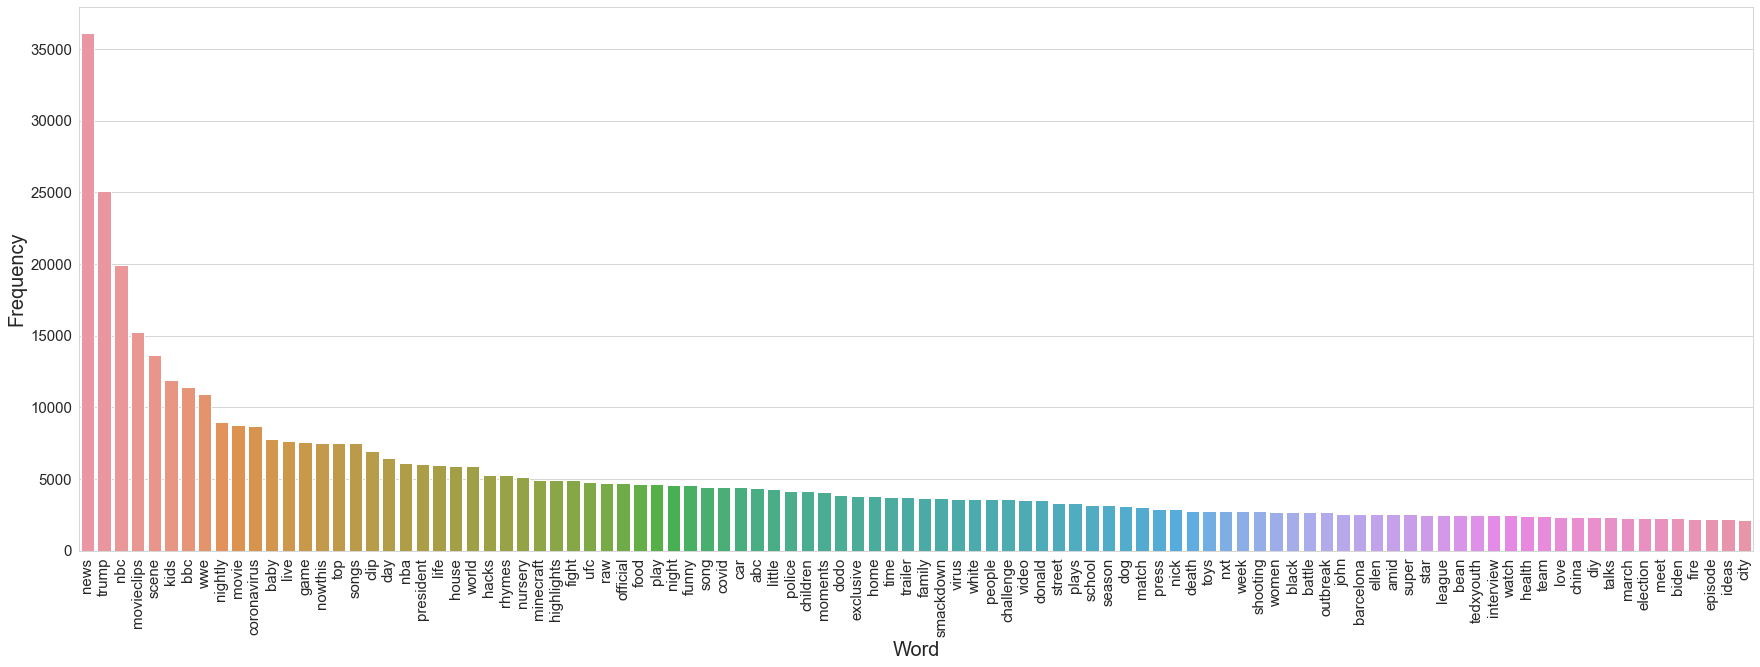

In [27]:
plt.figure(figsize=(30,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xticks(fontsize=15, rotation='vertical')
plt.yticks(fontsize=15)

#plt.savefig('WordFrequency.png')
plt.show()

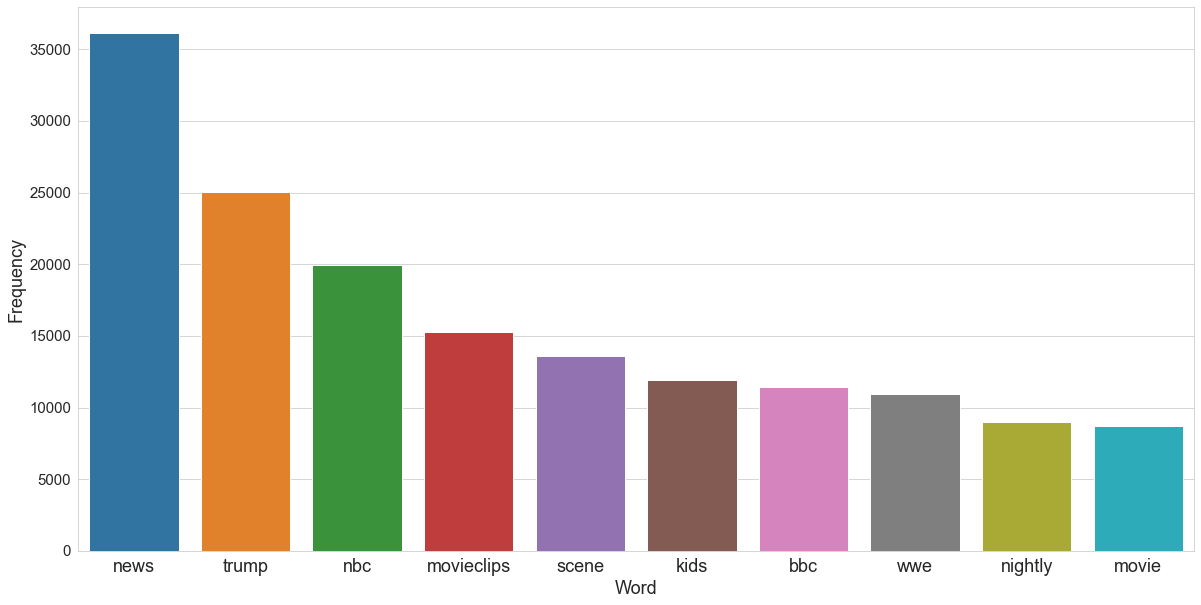

In [20]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(10))
plt.xlabel('Word', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=15)

#plt.savefig('Top10Words.Png')
plt.show()

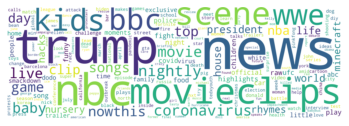

In [22]:
# Create and generate a word cloud image
wordcloud = WordCloud(background_color="white", width=3000, height=1000, stopwords = set(STOPWORDS)).generate_from_frequencies(word_dist)

# Display the generated image
plt.figure()
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#Save wordcloud to PNG
wordcloud.to_file('WordCloud.png')

## Sentiment Analysis

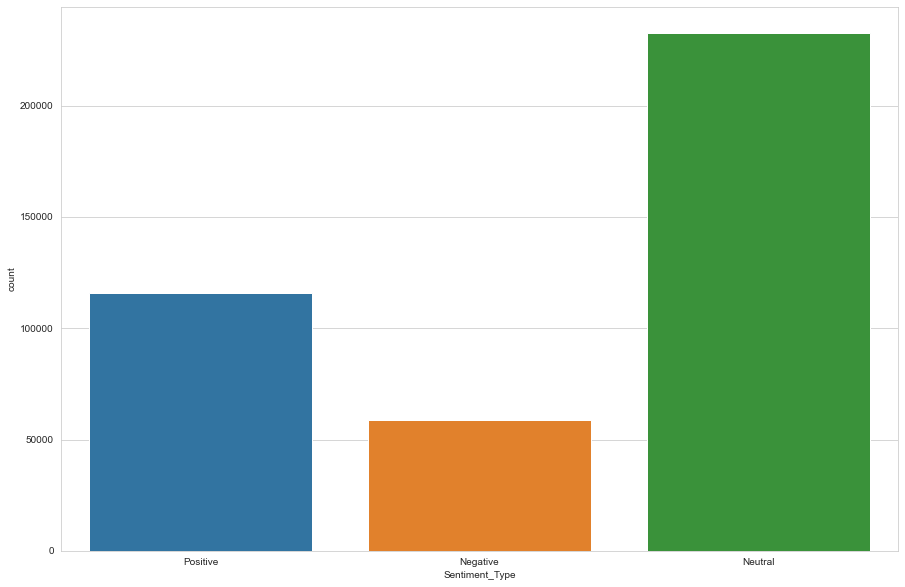

In [69]:
bloblist_title = list()

decodedTitles = videodf['decodedTitles']
for row in decodedTitles:
    blob = TextBlob(row)
    bloblist_title.append((row,blob.sentiment.polarity, blob.sentiment.subjectivity))
    videotitle_polarity = pd.DataFrame(bloblist_title, columns = ['sentence','sentiment','polarity'])
 
def f_title(videotitle_polarity):
    if videotitle_polarity['sentiment'] > 0:
        val = "Positive"
    elif videotitle_polarity['sentiment'] == 0:
        val = "Neutral"
    else:
        val = "Negative"
    return val

videotitle_polarity['Sentiment_Type'] = videotitle_polarity.apply(f_title, axis=1)

In [141]:
videoTitleSentiments = pd.merge(videodf['videoTitle'], videotitle_polarity, left_index=True, right_index=True)
videoTitleSentiments = pd.merge(videodf['videoId'], videoTitleSentiments, left_index=True, right_index=True)
videoTitleSentiments.to_csv('titleSentiments.csv',index = False, header=True)

In [142]:
videoTitleSentiments.head()

,videoId,videoTitle,sentence,sentiment,polarity,Sentiment_Type
0,NXX338WY_Lw,PREVIEW: Attempting 200mph in the Jaguar XJ220...,PREVIEW: Attempting 200mph in the Jaguar XJ220...,0.50,0.500000,Positive
1,dtHcdU2c71Y,Which car will win Top Gear Speed Week 2020? (...,Which car will win Top Gear Speed Week 2020? (...,0.60,0.466667,Positive
2,vnrtWe-RAzg,Chris Harris on... the Ferrari SF90 Stradale |...,Chris Harris on... the Ferrari SF90 Stradale |...,0.50,0.500000,Positive
3,Ra1F0TsOCPs,Chris Harris vs 2020’s Best Performance Cars |...,Chris Harris vs 2020’s Best Performance Cars |...,0.75,0.400000,Positive
4,fXysipmTxcQ,FASTEST TOP GEAR LAP? Ferrari SF90 Stiglap | T...,FASTEST TOP GEAR LAP? Ferrari SF90 Stiglap | T...,0.50,0.500000,Positive


In [86]:
positiveCount = len(videotitle_polarity.loc[ videotitle_polarity['Sentiment_Type']=='Positive'])
negativeCount = len(videotitle_polarity.loc[ videotitle_polarity['Sentiment_Type']=='Negative'])
neutralCount = len(videotitle_polarity.loc[ videotitle_polarity['Sentiment_Type']=='Neutral'])
print("Positive: " + str(positiveCount))
print("Negative: " + str(negativeCount))
print("Neutral: " + str(neutralCount))

Positive: 115767
Negative: 58723
Neutral: 232603


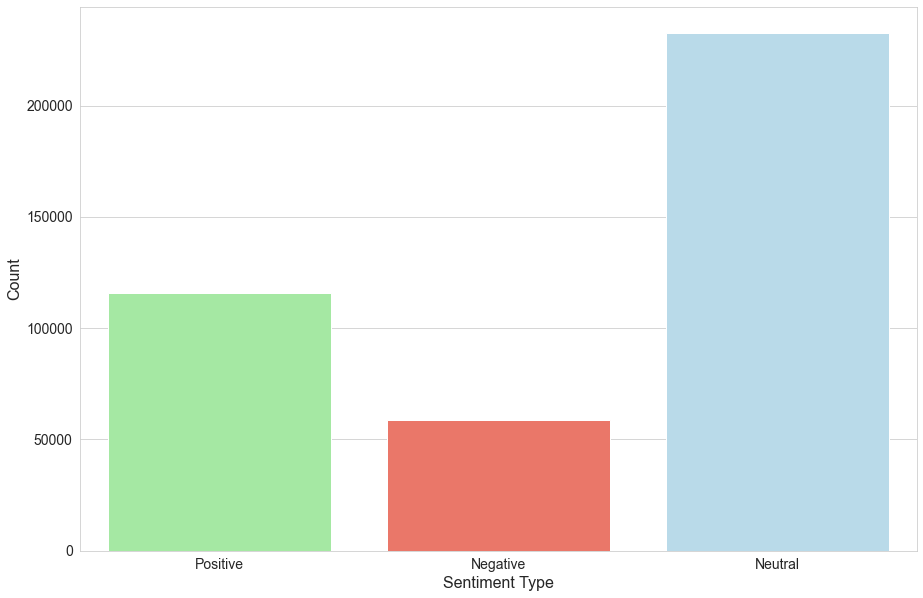

In [123]:
# Bar chart
plt.figure(figsize=(15,10))
sns.set_style("whitegrid")
ax = sns.countplot(x="Sentiment_Type", data=videotitle_polarity, palette=['#9af497','#ff6654','#b1ddf1'])
plt.xlabel('Sentiment Type', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('TitleSentimentsBar.png') 
plt.show()

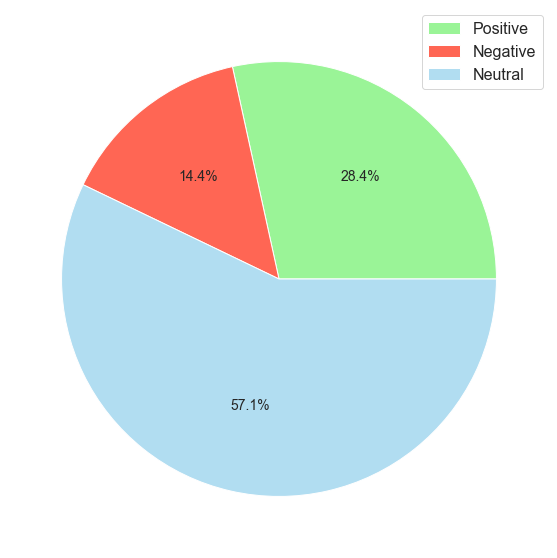

In [135]:
# Pie chart
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
plt.pie([positiveCount,negativeCount,neutralCount], colors=['#9af497','#ff6654','#b1ddf1'],autopct='%1.1f%%',textprops={'fontsize': 14})
plt.legend(labels=['Positive','Negative','Neutral'], prop={'size': 16})
#plt.savefig('TitleSentimentsPie.png') 
plt.show()